In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=6)
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(seasonal_time):
  return np.where(seasonal_time<0.4,
                  np.cos(seasonal_time*2*np.pi),
                  1/np.exp(3*seasonal_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  seasonal_time = ((time+phase)%period)/period
  return amplitude*seasonal_pattern(seasonal_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level


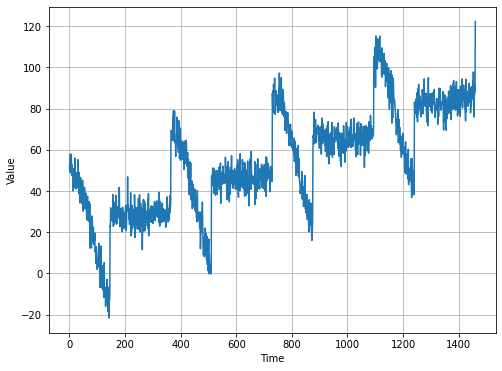

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(8,6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

**Stateful RNN**

In [6]:
def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=window_size, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  return ds.batch(1).prefetch(1)

In [7]:
#Lets visualize a sample data
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
  print('X: ', X_batch.numpy())
  print('y: ', y_batch.numpy())

X:  [[[0]
  [1]
  [2]]]
y:  [[[1]
  [2]
  [3]]]
X:  [[[3]
  [4]
  [5]]]
y:  [[[4]
  [5]
  [6]]]
X:  [[[6]
  [7]
  [8]]]
y:  [[[7]
  [8]
  [9]]]


In [11]:
#Custome Reset Class to reset states of the model
class ResetStatesCallBack(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
                                    keras.layers.SimpleRNN(100, batch_input_shape=[1, None, 1], return_sequences=True, stateful=True),
                                    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
                                    keras.layers.Dense(1),
                                    keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))
reset_state = ResetStatesCallBack()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_state])

Epoch 1/100
33/33 [==============================] - 4s 30ms/step - loss: 105.9340 - mae: 106.4340 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 21ms/step - loss: 70.8572 - mae: 71.3571 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 1s 22ms/step - loss: 39.8080 - mae: 40.3047 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 27.3450 - mae: 27.8404 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 24.4956 - mae: 24.9892 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 15ms/step - loss: 23.2601 - mae: 23.7517 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 1s 15ms/step - loss: 22.0604 - mae: 22.5533 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 20.8543 - mae: 21.3463 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 15ms/step - loss: 19.8307 - ma

(1e-08, 0.0001, 0.0, 30.0)

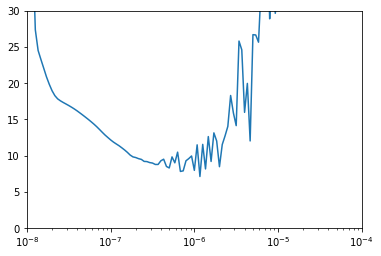

In [13]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
                                    keras.layers.SimpleRNN(100, batch_input_shape=[1, None, 1], return_sequences=True, stateful=True),
                                    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
                                    keras.layers.Dense(1),
                                    keras.layers.Lambda(lambda x: x*200)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)
reset_state = ResetStatesCallBack()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model_checkpoint = keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_state])

Epoch 1/500
33/33 [==============================] - 7s 61ms/step - loss: 60.2498 - mae: 60.7477 - val_loss: 25.0215 - val_mae: 25.5176
Epoch 2/500
33/33 [==============================] - 1s 32ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 1s 28ms/step - loss: 18.7249 - mae: 19.2166 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 1s 35ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 31ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 1s 24ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 26ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

In [16]:
model = tf.keras.models.load_model('model_checkpoint.h5')

In [18]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis]) #the model expects a 3 dim array. Hence buffered with 1, (input), 1
rnn_forecast = rnn_forecast[0, split_time-1: -1, 0]

In [19]:
rnn_forecast.shape

(461,)

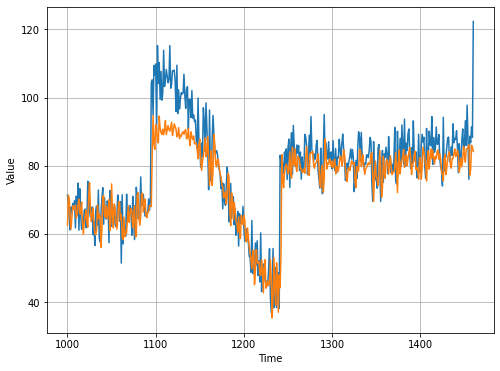

In [20]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [23]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778273